In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)


In [3]:
DATA_DIR = "../data/processed/cicids_v1_raw.csv"

df = pd.read_csv(DATA_DIR)


In [4]:
df["Label"].value_counts()


Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [5]:
df["label_bin"] = (df["Label"] != "BENIGN").astype(int)
df["label_bin"].value_counts(normalize=True)


label_bin
0    0.803004
1    0.196996
Name: proportion, dtype: float64

In [6]:
df.dtypes.value_counts()


int64      56
float64    24
str         4
Name: count, dtype: int64

In [7]:
non_numeric = df.select_dtypes(exclude=["number"]).columns
non_numeric


Index(['Label', 'source_file', 'day', 'attack_group'], dtype='str')

In [8]:
nan_counts = df.isna().sum()
inf_counts = np.isinf(df.select_dtypes("number")).sum()

nan_counts[nan_counts > 0].sort_values(ascending=False).head(15)


Flow Bytes/s    1358
dtype: int64

In [9]:
inf_counts[inf_counts > 0].sort_values(ascending=False).head(15)


Flow Packets/s    2867
Flow Bytes/s      1509
dtype: int64

In [10]:
numeric_df = df.select_dtypes("number").drop(columns=["label_bin"])

summary = numeric_df.describe(
    percentiles=[.01, .05, .25, .5, .75, .95, .99]
).T

summary.head()


d:\Coding\VanetUAV\.venv\Lib\site-packages\pandas\core\nanops.py:1020: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
d:\Coding\VanetUAV\.venv\Lib\site-packages\pandas\core\nanops.py:1020: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.0,22.0,53.0,53.0,80.0,443.0,55228.0,6.165200e+04,65535.0
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-13.0,1.0,4.0,155.0,31316.0,3204828.5,101114583.8,1.177776e+08,119999998.0
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.0,1.0,1.0,2.0,2.0,5.0,19.0,4.800000e+01,219759.0
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.0,0.0,0.0,1.0,2.0,4.0,17.0,5.700000e+01,291922.0
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.0,0.0,0.0,12.0,62.0,187.0,1775.0,1.159500e+04,12900000.0


In [11]:
low_variance = [
    c for c in numeric_df.columns
    if numeric_df[c].nunique() <= 5
]

len(low_variance), low_variance


(19,
 ['Fwd PSH Flags',
  'Bwd PSH Flags',
  'Fwd URG Flags',
  'Bwd URG Flags',
  'FIN Flag Count',
  'SYN Flag Count',
  'RST Flag Count',
  'PSH Flag Count',
  'ACK Flag Count',
  'URG Flag Count',
  'CWE Flag Count',
  'ECE Flag Count',
  'Fwd Avg Bytes/Bulk',
  'Fwd Avg Packets/Bulk',
  'Fwd Avg Bulk Rate',
  'Bwd Avg Bytes/Bulk',
  'Bwd Avg Packets/Bulk',
  'Bwd Avg Bulk Rate',
  'label_binary'])

In [12]:
range_report = []

for c in numeric_df.columns:
    benign = df[df.label_bin == 0][c].replace([np.inf, -np.inf], np.nan).dropna()
    attack = df[df.label_bin == 1][c].replace([np.inf, -np.inf], np.nan).dropna()

    if len(benign) == 0 or len(attack) == 0:
        continue

    overlap = min(benign.max(), attack.max()) - max(benign.min(), attack.min())

    range_report.append({
        "feature": c,
        "benign_min": benign.min(),
        "benign_max": benign.max(),
        "attack_min": attack.min(),
        "attack_max": attack.max(),
        "overlap": overlap
    })

range_df = pd.DataFrame(range_report)


In [13]:
range_df.sort_values("overlap").head(10)


,feature,benign_min,benign_max,attack_min,attack_max,overlap
78,label_binary,0.0,0.0,1.0,1.0,-1.0
31,Bwd PSH Flags,0.0,0.0,0.0,0.0,0.0
61,Bwd Avg Bulk Rate,0.0,0.0,0.0,0.0,0.0
50,ECE Flag Count,0.0,1.0,0.0,0.0,0.0
59,Bwd Avg Bytes/Bulk,0.0,0.0,0.0,0.0,0.0
58,Fwd Avg Bulk Rate,0.0,0.0,0.0,0.0,0.0
57,Fwd Avg Packets/Bulk,0.0,0.0,0.0,0.0,0.0
60,Bwd Avg Packets/Bulk,0.0,0.0,0.0,0.0,0.0
49,CWE Flag Count,0.0,1.0,0.0,0.0,0.0
45,RST Flag Count,0.0,1.0,0.0,0.0,0.0


d:\Coding\VanetUAV\.venv\Lib\site-packages\pandas\core\nanops.py:1020: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\vpahu\AppData\Local\Temp\ipykernel_11456\4222611935.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df.label_bin==0][feat], label="benign", log_scale=True)
C:\Users\vpahu\AppData\Local\Temp\ipykernel_11456\4222611935.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df.label_bin==1][feat], label="attack", log_scale=True)
C:\Users\vpahu\AppData\Local\Temp\ipykernel_11456\4222611935.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


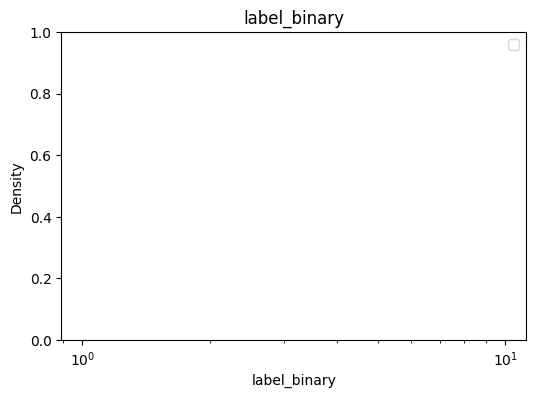

In [14]:
feat = range_df.sort_values("overlap").iloc[0]["feature"]

plt.figure(figsize=(6,4))
sns.kdeplot(df[df.label_bin==0][feat], label="benign", log_scale=True)
sns.kdeplot(df[df.label_bin==1][feat], label="attack", log_scale=True)
plt.legend()
plt.title(feat)
plt.show()
